In [44]:
!pip freeze > requirements_before.txt  
!pip install holidays
import holidays
import pandas as pd
import tslearn
import umap 
import tsfresh
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
!pip check


No broken requirements found.


Домашнее задание
Скажи мне, кто твой друг, и я скажу, какой у тебя clustering coefficient

Цель:
В этом домашнем задании вам предлагается провести исследование по кластеризации временных рядов, основанное на данных о потребительском поведении.

1.  
Для начала проведите исследовательский анализ данных, Откорректируйте верно формат даты и времени, обработайте пропуски и выбросы, если они имеются.  
ВНИМАНИЕ! Дополнительно можно выполнить извлечение признаков из табличных данных. Извлеките признаки из временных рядов, такие как:  
Общее количество покупок за период  
Средняя сумма покупки  
Частота покупок (количество транзакций в неделю/месяц)  
Сезонные паттерны (например, увеличение покупок в праздничные дни)  
Временные интервалы между покупками и др.  


In [2]:
df_raw = pd.read_excel("D:\OTUS_ML_Advanced\HW1\online+retail\Online Retail.xlsx")
df_raw.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
240665,558107,23202,JUMBO BAG VINTAGE LEAF,3,2011-06-26 15:09:00,2.08,17811.0,United Kingdom
155941,550034,22741,FUNKY DIVA PEN,48,2011-04-14 11:48:00,0.85,16187.0,United Kingdom
471886,576654,23582,VINTAGE DOILY JUMBO BAG RED,2,2011-11-16 10:55:00,2.08,15584.0,United Kingdom
44399,540169,48188,DOORMAT WELCOME PUPPIES,1,2011-01-05 12:20:00,7.95,14527.0,United Kingdom
194215,553556,21224,SET/4 SKULL BADGES,5,2011-05-17 16:48:00,1.25,17530.0,United Kingdom


In [14]:
df_raw.info(),df_raw.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


(None,
             Quantity                    InvoiceDate      UnitPrice  \
 count  541909.000000                         541909  541909.000000   
 mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
 min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
 25%         1.000000            2011-03-28 11:34:00       1.250000   
 50%         3.000000            2011-07-19 17:17:00       2.080000   
 75%        10.000000            2011-10-19 11:27:00       4.130000   
 max     80995.000000            2011-12-09 12:50:00   38970.000000   
 std       218.081158                            NaN      96.759853   
 
           CustomerID  
 count  406829.000000  
 mean    15287.690570  
 min     12346.000000  
 25%     13953.000000  
 50%     15152.000000  
 75%     16791.000000  
 max     18287.000000  
 std      1713.600303  )

In [15]:
missing = df_raw.isna().mean().sort_values(ascending=False)  
print("Доля пропусков\n", missing)

# создадим глубокую копию
df = df_raw.copy()
# пусть будет строковым/object либо nullable Int32
df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce').astype('Int32')

# Откорректируйте верно формат даты и времени
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['Month'] = df['InvoiceDate'].dt.month  
df['Week']  = df['InvoiceDate'].dt.isocalendar().week.astype('uint8')  
df['Dow']   = df['InvoiceDate'].dt.dayofweek  # 0=Mon … 6=Sun
df['Hour']  = (df['InvoiceDate'].dt.hour ).astype('uint8')     # 1–24
print('\n','df.sample(5)',df.sample(5)   )

# обработайте пропуски и выбросы, если они имеются. - есть отрицательные Quantity ,UnitPrice , что ,вероятно ,возврат товара. Оставить их или удалить ? Удалим.
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0 )].copy()
# Добавим стоимость скаждого товара в чеке 
df['LineTotal'] = (df['Quantity'] * df['UnitPrice']).astype('float64')
# print(df.describe())
print('\n',"df.describe()",df.describe())

Доля пропусков
 CustomerID     0.249267
Description    0.002683
InvoiceNo      0.000000
StockCode      0.000000
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
Country        0.000000
dtype: float64

 df.sample(5)        InvoiceNo StockCode                         Description  Quantity  \
213046    555517     22328  ROUND SNACK BOXES SET OF 4 FRUITS          6   
214043    555564     47566                       PARTY BUNTING         1   
440550    574536     21912            VINTAGE SNAKES & LADDERS         2   
356610    568057     23245          SET OF 3 REGENCY CAKE TINS         1   
233781    557489     23200                     JUMBO BAG PEARS        10   

               InvoiceDate  UnitPrice  CustomerID         Country  Month  \
213046 2011-06-05 10:54:00       2.95       13131  United Kingdom      6   
214043 2011-06-05 15:01:00       4.95       15005  United Kingdom      6   
440550 2011-11-04 14:35:00       3.75       15707  United Kingdom     11   
3

In [16]:
# доля пропусков
print('доля пропусков ',df['CustomerID'].isna().sum()/df['CustomerID'].isna().count() , df['CustomerID'].isna().mean())

# 4338 клиентов 
print('Количество клиентов',df['CustomerID'].value_counts().count())

# общее количество покупок
print('Общее количество покупок',df['InvoiceNo'].value_counts().count())

mask_yes_id = df['CustomerID'].notna()  

orders_yes_id = (  
    df.loc[mask_yes_id, 'InvoiceNo']       
      .nunique()                          
)  

print('Чеков (покупок) С CustomerID :', orders_yes_id)

mask_no_id = df['CustomerID'].isna()  

orders_no_id = (  
    df.loc [mask_no_id, 'InvoiceNo']       # берём только строки без ID  
      .nunique()                          # считаем уникальные чеки  
)  

print('Чеков (покупок) без CustomerID :', orders_no_id)

(orders_no_id + orders_yes_id ) == df['InvoiceNo'].value_counts().count()
# количество чеков сходится

доля пропусков  0.24942275478019407 0.24942275478019407
Количество клиентов 4338
Общее количество покупок 19960
Чеков (покупок) С CustomerID : 18532
Чеков (покупок) без CustomerID : 1428


True

In [17]:
df_anon  = df[df['CustomerID'].isna()].copy()
df_anon.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Week,Dow,Hour,LineTotal
10892,537240,22523,CHILDS GARDEN FORK PINK,1,2010-12-06 10:08:00,1.66,<NA>,United Kingdom,12,49,0,10,1.66
245280,558614,21990,MODERN FLORAL STATIONERY SET,5,2011-06-30 15:56:00,2.46,<NA>,United Kingdom,6,26,3,15,12.30
460904,575930,22595,GINGHAM HEART DECORATION,1,2011-11-11 17:58:00,1.63,<NA>,United Kingdom,11,45,4,17,1.63
36844,539453,22546,MINI JIGSAW PURDEY,1,2010-12-17 17:08:00,0.85,<NA>,United Kingdom,12,50,4,17,0.85
177439,552063,23206,LUNCH BAG APPLE DESIGN,1,2011-05-06 10:51:00,1.65,<NA>,United Kingdom,5,18,4,10,1.65


In [18]:
df_cust = df[df['CustomerID'].notna()].copy()
df_cust.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Week,Dow,Hour,LineTotal
397033,571117,21980,PACK OF 12 RED RETROSPOT TISSUES,24,2011-10-13 17:51:00,0.39,16224,United Kingdom,10,41,3,17,9.36
27986,538593,21524,DOORMAT SPOTTY HOME SWEET HOME,10,2010-12-13 11:51:00,6.75,16701,United Kingdom,12,50,0,11,67.50
383447,570022,23028,DRAWER KNOB CRACKLE GLAZE BLUE,2,2011-10-07 10:21:00,1.65,14067,United Kingdom,10,40,4,10,3.30
474056,576838,84836,ZINC METAL HEART DECORATION,12,2011-11-16 15:21:00,1.25,18075,United Kingdom,11,46,2,15,15.00
377648,569559,21213,PACK OF 72 SKULL CAKE CASES,24,2011-10-05 09:31:00,0.55,12971,United Kingdom,10,40,2,9,13.20


In [19]:
# праздники

#  период времени
print(df_cust['InvoiceDate'].min() , df_cust['InvoiceDate'].max())

countries = df_cust.Country.value_counts().sort_values(ascending=False).index.tolist()
print(countries)

# ------------------ настройте здесь ------------------
years_range = range(2010, 2012)   # какие годы нужны
countries   = df_cust['Country'].dropna().unique().tolist()  # или другой список

manual_map = {
    # нестандартные подписи  →  правильное имя класса holidays
    'EIRE'            : 'Ireland',
    'RSA'             : 'SouthAfrica',
    'U.S.A.'          : 'UnitedStates',
    'USA'             : 'UnitedStates',
    'Channel Islands' : 'UnitedKingdom',
}
# ------------------------------------------------------

def normalize(name: str) -> str:
    """Убирает пробелы, тире, точки и & для поиска класса."""
    return name.replace(' ', '').replace('-', '').replace('.', '').replace('&', '')

country_holidays = {}

for country in countries:
    # 1) ручная карта
    cls_name = manual_map.get(country)
    
    # 2) если не нашли — пытаемся угадать автоматически
    if cls_name is None:
        cand = normalize(country)
        cls_name = cand if hasattr(holidays, cand) else None
    
    # 3) если класса нет, кладём пустое множество и пишем предупреждение
    if cls_name is None:
        country_holidays[country] = set()
        print(f'⚠️  Праздники для "{country}" не найдены: добавлен пустой set()')
        continue
    
    # 4) создаём календарь и добавляем в словарь
    HolidayCls = getattr(holidays, cls_name)
    country_holidays[country] = HolidayCls(years=years_range)

# ------------------ проверка ------------------
print(f'Обработано стран: {len(country_holidays)}')
for k, v in list(country_holidays.items())[:5]:
    print(f'{k:20}: {len(v)} дат')

# первые 5 старн из словаря праздничных дней
pd.Series(country_holidays).loc[countries[:5]]         # страны = индекс, значения = наборы праздников

# print(country_holidays)

# 1. Флаг «это праздничный день в стране покупки?»
df_cust['IsHoliday'] = df_cust.apply(
    lambda r:                                   # r — одна строка DataFrame
        r['InvoiceDate'].date()
        in country_holidays.get(r['Country'], set()),
    axis=1
)

# количество покупок в праздники = 1287/
print( 'покупок в праздники - ', len(df_cust[df_cust['IsHoliday']==True]), 'доля в общем количестве покупок - ',len(df_cust[df_cust['IsHoliday']==True]) / df_cust['InvoiceNo'].nunique() )

2010-12-01 08:26:00 2011-12-09 12:50:00
['United Kingdom', 'Germany', 'France', 'EIRE', 'Spain', 'Netherlands', 'Belgium', 'Switzerland', 'Portugal', 'Australia', 'Norway', 'Italy', 'Channel Islands', 'Finland', 'Cyprus', 'Sweden', 'Austria', 'Denmark', 'Poland', 'Japan', 'Israel', 'Unspecified', 'Singapore', 'Iceland', 'USA', 'Canada', 'Greece', 'Malta', 'United Arab Emirates', 'European Community', 'RSA', 'Lebanon', 'Lithuania', 'Brazil', 'Czech Republic', 'Bahrain', 'Saudi Arabia']
⚠️  Праздники для "Lebanon" не найдены: добавлен пустой set()
⚠️  Праздники для "Czech Republic" не найдены: добавлен пустой set()
⚠️  Праздники для "Unspecified" не найдены: добавлен пустой set()
⚠️  Праздники для "European Community" не найдены: добавлен пустой set()
Обработано стран: 37
United Kingdom      : 17 дат
France              : 22 дат
Australia           : 13 дат
Netherlands         : 19 дат
Germany             : 18 дат
покупок в праздники -  1287 доля в общем количестве покупок -  0.069447442

In [20]:
# ВНИМАНИЕ! Дополнительно можно выполнить извлечение признаков из табличных данных. Извлеките признаки из временных рядов, такие как:
# Общее количество покупок за период
# Средняя сумма покупки
# Частота покупок (количество транзакций в неделю/месяц)
# Сезонные паттерны (например, увеличение покупок в праздничные дни)
# Временные интервалы между покупками и др.

# 📆 Сортировка для корректных интервалов
df_cust.sort_values(by=['CustomerID', 'InvoiceDate'], inplace=True)

# 📊 Поведенческие признаки
total_qty = df_cust.groupby('CustomerID')['Quantity'].sum().rename('TotalQuantity')
total_spent = df_cust.groupby('CustomerID')['LineTotal'].sum().rename('TotalSpent')
avg_check = df_cust.groupby('CustomerID')['LineTotal'].mean().rename('AvgCheck')

weekly_freq = (
    df_cust.set_index('InvoiceDate')
    .groupby('CustomerID')
    .resample('W')['InvoiceNo'].nunique()
    .groupby('CustomerID')
    .mean()
    .rename('WeeklyFrequency')
)

avg_interval = (
    df_cust.groupby('CustomerID')['InvoiceDate']
    .diff()
    .dt.days
    .groupby(df_cust['CustomerID'])
    .mean()
    .rename('AvgPurchaseInterval')
)

# 📅 Сезонность: коэффициент вариации по месяцам
monthly = df_cust.groupby(['CustomerID', 'Month'])['InvoiceNo'].count().unstack(fill_value=0)
seasonality_cv = monthly.std(axis=1) / monthly.mean(axis=1)
seasonality_cv.name = 'MonthlyCV'

# 🕒 Средний час и день недели активности
avg_hour = df_cust.groupby('CustomerID')['Hour'].mean().rename('AvgHour')
avg_dow = df_cust.groupby('CustomerID')['Dow'].mean().rename('AvgDow')

# 📈 Распределение покупок по месяцам (доли)
monthly_share = monthly.div(monthly.sum(axis=1), axis=0)
monthly_share.columns = [f'MonthShare_{m}' for m in monthly_share.columns]


if 'IsHoliday' not in df_cust.columns:
    df_cust['IsHoliday'] = df_cust.apply(
        lambda r: r['InvoiceDate'].date() in country_holidays.get(r['Country'], set()),
        axis=1
    )

# ② агрегируем: сколько/какая доля чеков у клиента пришлась на праздники
holiday_cnt   = (
    df_cust.groupby('CustomerID')['IsHoliday']
           .sum()
           .rename('HolidayCnt')          # количество
)
holiday_share = (
    df_cust.groupby('CustomerID')['IsHoliday']
           .mean()
           .rename('HolidayShare')        # доля (0‒1)
)

# ③ включаем эти признаки в общий датафрейм
df_features = pd.concat([
    total_qty, total_spent, avg_check, weekly_freq, avg_interval,
    seasonality_cv, avg_hour, avg_dow, monthly_share,
    # holiday_cnt, holiday_share             # ← добавили сюда
], axis=1).dropna()

# ⚙️ Масштабирование признаков
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_features),
    index=df_features.index,
    columns=df_features.columns
)
df_scaled.head()


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,0.255510,0.249773,-0.025726,-0.574352,-0.115814,-1.420457,-0.196647,-0.765990,0.644704,-0.314984,-0.369425,0.383600,-0.387411,0.177115,-0.358107,0.348556,-0.452512,0.470474,-0.558405,0.557832
12348,0.231925,-0.029851,0.012885,-0.623908,0.564906,-0.563586,1.400349,0.011690,0.849748,-0.314984,-0.369425,0.544159,-0.387411,-0.369116,-0.358107,-0.356311,-0.039665,-0.490017,-0.558405,1.944187
12349,-0.112778,-0.034268,-0.025282,0.671830,-0.299792,1.092885,-1.877248,-1.722045,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,3.001947,-0.449443
12350,-0.200265,-0.192639,-0.030242,0.671830,-0.299792,1.092885,1.807926,-0.378401,-0.310401,5.550850,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,-0.449443
12352,-0.131929,0.049025,-0.019194,-0.461711,-0.017254,-0.952872,0.773600,-0.473246,-0.310401,0.720163,0.966029,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,1.153546,-0.490017,0.069892,-0.449443


In [21]:
df_features.head()

,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,2458,4310.00,23.681319,0.132075,2.000000,1.165589,12.192308,1.423077,0.159341,0.000000,0.000000,0.131868,0.0,0.098901,0.0,0.120879,0.000000,0.258242,0.000000,0.230769
12348,2341,1797.24,57.975484,0.097561,9.400000,1.949218,15.225806,2.580645,0.193548,0.000000,0.000000,0.161290,0.0,0.000000,0.0,0.000000,0.096774,0.000000,0.000000,0.548387
12349,631,1757.55,24.076027,1.000000,0.000000,3.464102,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
12350,197,334.40,19.670588,1.000000,0.000000,3.464102,16.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
12352,536,2506.04,29.482824,0.210526,3.071429,1.593207,14.035294,1.858824,0.000000,0.176471,0.270588,0.000000,0.0,0.000000,0.0,0.000000,0.376471,0.000000,0.176471,0.000000


## 1 Иерархическая кластеризация

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
• y — исходные данные:
– (n × m) array-like ‒ матрица признаков, либо
– (n × (n−1)/2) condensed vector ‒ уже вычислённые попарные расстояния (как из pdist).

• method — стратегия агломерации. Основные:
– 'single', 'complete', 'average', 'weighted',
– 'ward' (использует SSE; метрический аргумент игнорируется),
– 'centroid', 'median', 'ward', 'distance'.

• metric — метрика расстояния (работает только, если в y подаётся матрица признаков). Любое из того, что знает scipy.spatial.distance.pdist ('euclidean', 'cityblock', 'cosine' и т. д) или ваша функция.
• optimal_ordering (False) — если True, используется O(n³) алгоритм, упорядочивающий листья так, чтобы минимизировать сумму длин ветвей; полезно, когда важна «красота» дендрограммы.

Алгоритмы агломерации (аргумент method)
(упорядочены по популярности)
• 'single'    – одинарная (минимальное расстояние между элементами двух кластеров)
• 'complete'   – полная (максимальное расстояние)
• 'average'   – UPGMA: среднее попарное расстояние (поддерживает любые метрики)
• 'weighted'  – WPGMA: среднее, но с весами по размерам кластеров
• 'ward'    – минимизация прироста суммарной квадратичной ошибки (SSE); требует евклидово расстояние
• 'centroid'   – расстояние между центроидами; подразумевает евклидову метрику
• 'median'   – похож на centroid, но центроид пересчитывается иначе; тоже «зашит» Euclidean

Практика:
• Если данные имеют чёткую «шар-образную» структуру и важна компактность — пробуйте 'ward'.
• Для вытянутых кластеров «single» может давать «цепочки» (chaining) — будьте осторожны.
• 'complete' и 'average' наиболее «универсальны», дают умеренно компактные, но разделённые кластеры.

────────────────────────
2. Метрики расстояния (аргумент metric)

• Для 'ward', 'centroid', 'median' игнорируется — всегда используется Euclidean.
• Для остальных можно подставлять любую строку, поддерживаемую scipy.spatial.distance.pdist, либо собственную функцию.

Часто используемые непрерывные метрики
• 'euclidean'   — √∑(xi − yi)² (по умолчанию)
• 'cityblock' / 'manhattan' — ∑|xi − yi|
• 'chebyshev'     — max|xi − yi|
• 'minkowski' (p) — обобщение Euclidean/Manhattan (задайте p= в pdist)
• 'cosine'      — 1 − cos( θ ) между векторами
• 'correlation'  — 1 − коэффициент корреляции Пирсона
• 'mahalanobis' — √((x − y)ᵀ S⁻¹ (x − y)), где S — ковариационная матрица (нормирует по дисперсии)

Метрики для бинарных (0/1) признаков
• 'hamming', 'jaccard', 'dice', 'kulsinski',
• 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'yule'.

3. Шпаргалка выбора

Хотите компактные шарообразные группы → method='ward', metric='euclidean'.
Хотите устойчивость к «цепочкам» и разному масштабу → method='complete', metric='euclidean' или 'average'.
Данные бинарные → оставляете метод 'average' (или 'complete') и ставите бинарную метрику, например 'jaccard'.
Векторы — это направления в пространстве (тексты, TF-IDF) → 'average', metric='cosine'

In [22]:
import inspect, scipy.spatial.distance as ssd
metrics = ssd._METRICS.keys()        # строки-идентификаторы
print(sorted(metrics))

['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulczynski1', 'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']


10 кластеров ?


добавление праздников сильно искажает картину

Silhouette говорит: «2 кластера — математически чище, но всё остальное весьма размыто».

Elbow говорит: «если нужно детальнее, 5–7 кластеров ещё оправданы; после этого улучшение минимально».

Дендограмма говорит: «на высоте ~25 действительно отделяется 6–7 ветвей».

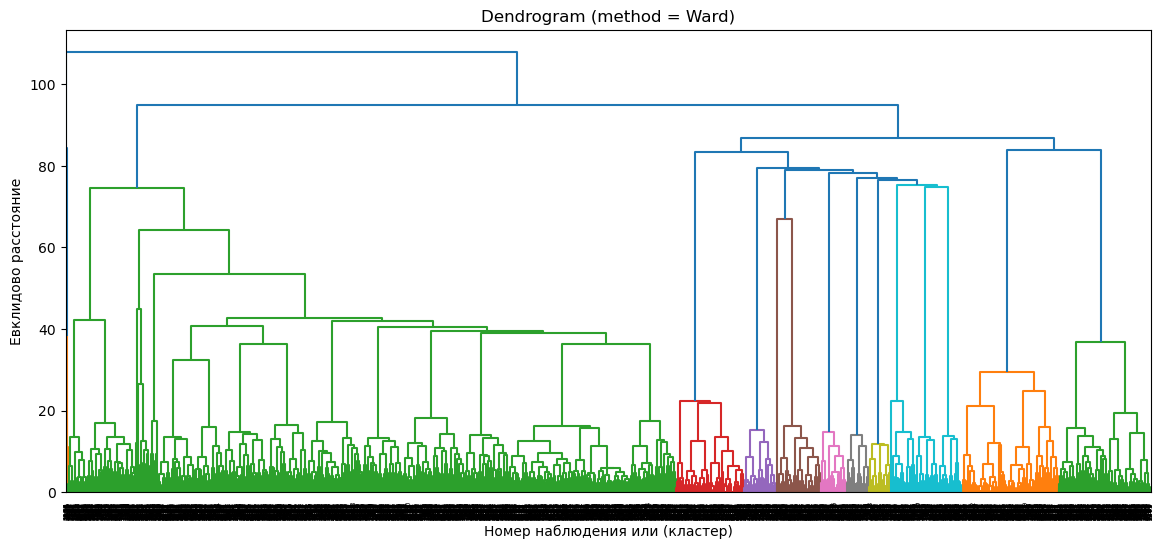

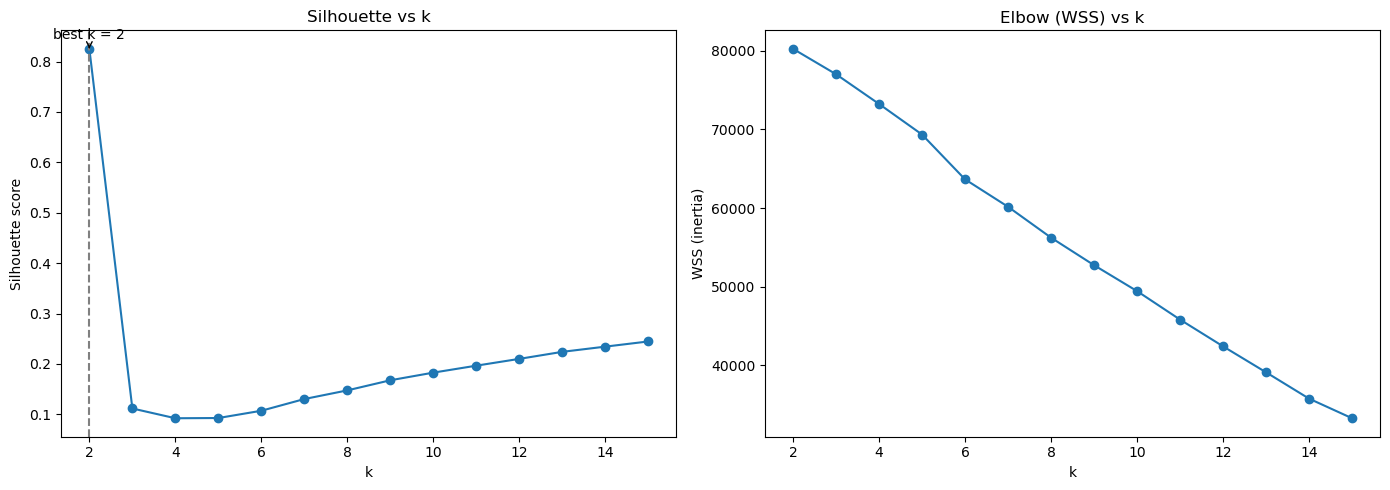


Распределение по кластерам:
Cluster
0    4259
1       8
Name: count, dtype: int64

Средние значения признаков по кластерам:


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
Cluster,,,,,,,,,,,,,,,,,,,,
0,1030.20,1745.34,33.04,0.53,3.24,2.47,12.57,2.56,0.05,0.05,0.07,0.06,0.07,0.07,0.06,0.06,0.11,0.13,0.16,0.1
1,86512.75,172508.53,7231.37,1.16,13.14,0.92,11.66,2.06,0.06,0.06,0.06,0.02,0.15,0.09,0.06,0.09,0.11,0.10,0.10,0.1


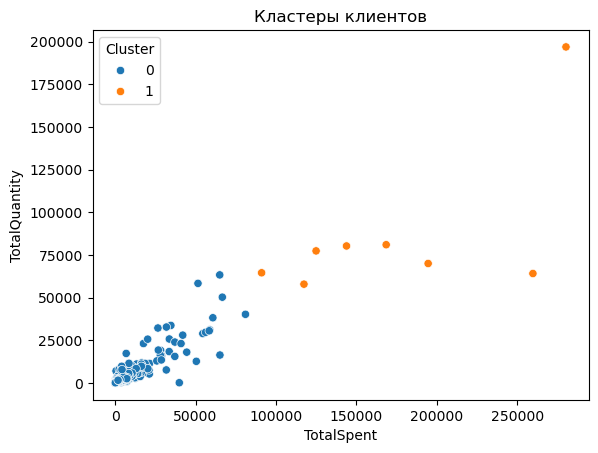

In [23]:
# --- Импорты ---------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display

# Предполагаем, что у вас уже есть:
# df_features – оригинальные признаки
# df_scaled   – их масштабированная версия (Pandas DataFrame той же формы)

# --- 1. Дендограмма --------------------------------------------------------
plt.figure(figsize=(14, 6))
Z = linkage(df_scaled, method='ward')                   # матрица связей
dendrogram(Z, truncate_mode='level', p=25)              # верхние 25 уровней
plt.title('Dendrogram (method = Ward)')
plt.xlabel('Номер наблюдения или (кластер)')
plt.ylabel('Евклидово расстояние')
plt.show()

# --- 2. Silhouette и Elbow --------------------------------------------------
k_min, k_max = 2, 15
sil_vals, wss_vals = [], []

for k in range(k_min, k_max + 1):
    # Agglomerative для Silhouette
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(df_scaled)
    sil_vals.append(silhouette_score(df_scaled, labels))
    
    # K-Means для WSS («локоть»)
    km = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    km.fit(df_scaled)
    wss_vals.append(km.inertia_)

# --- 3. Визуализация метрик -------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

k_range = range(k_min, k_max + 1)
best_k  = k_range[np.argmax(sil_vals)]                  # максимум силуэта

# Silhouette plot
ax[0].plot(k_range, sil_vals, marker='o')
ax[0].axvline(best_k, ls='--', c='grey')
ax[0].set_title('Silhouette vs k')
ax[0].set_xlabel('k');  ax[0].set_ylabel('Silhouette score')
ax[0].annotate(f'best k = {best_k}',
               xy=(best_k, max(sil_vals)),
               xytext=(best_k, max(sil_vals)+0.02),
               ha='center', arrowprops=dict(arrowstyle='->'))

# Elbow plot
ax[1].plot(k_range, wss_vals, marker='o')
ax[1].set_title('Elbow (WSS) vs k')
ax[1].set_xlabel('k'); ax[1].set_ylabel('WSS (inertia)')

plt.tight_layout(); plt.show()

# --- 4. Финальная модель ----------------------------------------------------
final_model    = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
cluster_labels = final_model.fit_predict(df_scaled)

# --- 5. Запись кластера в таблицы -------------------------------------------
df_scaled['Cluster']   = cluster_labels
df_features['Cluster'] = cluster_labels                 # если нужен в «сырой» таблице

print('\nРаспределение по кластерам:')
print(df_scaled['Cluster'].value_counts().sort_index())

print('\nСредние значения признаков по кластерам:')
cluster_profile = df_features.groupby('Cluster').mean().round(2)
display(cluster_profile)

# --- 6. Быстрая визуализация -------------------------------------------------
sns.scatterplot(data=df_features,
                x='TotalSpent', y='TotalQuantity',
                hue='Cluster', palette='tab10')
plt.title('Кластеры клиентов')
plt.show()

In [24]:
print(df_scaled.columns)
df_scaled.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_scaled

Index(['TotalQuantity', 'TotalSpent', 'AvgCheck', 'WeeklyFrequency',
       'AvgPurchaseInterval', 'MonthlyCV', 'AvgHour', 'AvgDow', 'MonthShare_1',
       'MonthShare_2', 'MonthShare_3', 'MonthShare_4', 'MonthShare_5',
       'MonthShare_6', 'MonthShare_7', 'MonthShare_8', 'MonthShare_9',
       'MonthShare_10', 'MonthShare_11', 'MonthShare_12', 'Cluster'],
      dtype='object')


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,0.255510,0.249773,-0.025726,-0.574352,-0.115814,-1.420457,-0.196647,-0.765990,0.644704,-0.314984,-0.369425,0.383600,-0.387411,0.177115,-0.358107,0.348556,-0.452512,0.470474,-0.558405,0.557832
12348,0.231925,-0.029851,0.012885,-0.623908,0.564906,-0.563586,1.400349,0.011690,0.849748,-0.314984,-0.369425,0.544159,-0.387411,-0.369116,-0.358107,-0.356311,-0.039665,-0.490017,-0.558405,1.944187
12349,-0.112778,-0.034268,-0.025282,0.671830,-0.299792,1.092885,-1.877248,-1.722045,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,3.001947,-0.449443
12350,-0.200265,-0.192639,-0.030242,0.671830,-0.299792,1.092885,1.807926,-0.378401,-0.310401,5.550850,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,-0.449443
12352,-0.131929,0.049025,-0.019194,-0.461711,-0.017254,-0.952872,0.773600,-0.473246,-0.310401,0.720163,0.966029,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,1.153546,-0.490017,0.069892,-0.449443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,-0.230905,-0.209754,-0.032055,0.671830,-0.299792,1.092885,-1.877248,-1.722045,-0.310401,-0.314984,4.565946,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,-0.449443
18281,-0.229091,-0.220857,-0.039390,0.671830,-0.299792,1.092885,-1.350795,2.308888,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,5.153886,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,-0.449443
18282,-0.219213,-0.210037,-0.035683,-0.604453,0.687001,-0.098990,-0.210146,0.965244,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,3.045205,-0.452512,-0.490017,-0.558405,1.369247


### Time Series Bag-of-Features

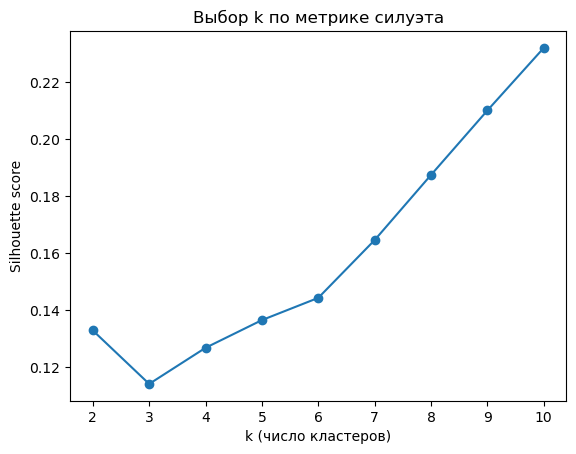

Лучшее k = 10, silhouette = 0.232
Число клиентов в кластерах: 4267
Cluster
0     217
1    1758
2     340
3       8
4     434
5     415
6     210
7     407
8     306
9     172
Name: count, dtype: int64

Центроиды (усреднённые признаки каждого кластера):


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
0,-0.149592,-0.125431,0.050110,0.035988,0.042699,0.346932,0.076994,0.042080,-0.218011,-0.264228,-0.297143,-0.256592,-0.278189,3.716974,-0.230437,-0.214338,-0.285409,-0.374425,-0.369120,-0.374637
1,0.143298,0.126347,-0.017531,-0.334401,0.085179,-0.841342,-0.056830,0.006438,-0.006841,0.391012,-0.056974,-0.032742,0.463612,-0.044128,-0.001963,0.029462,-0.093270,-0.148789,-0.157415,-0.099276
2,-0.140970,-0.142366,-0.022021,0.097380,-0.095606,0.491114,0.090251,0.088272,-0.262281,-0.271219,-0.258895,-0.271557,-0.328692,-0.325884,-0.327835,-0.320503,2.983858,-0.373057,-0.326288,-0.369692
3,17.199358,18.967172,8.089371,0.906098,0.908775,-1.689593,-0.474446,-0.339604,0.042002,0.047507,-0.091321,-0.213123,0.440912,0.101455,0.005852,0.164727,0.035454,-0.125829,-0.203743,-0.010686
4,-0.161150,-0.159499,-0.028832,0.379871,-0.144034,0.721172,0.156413,-0.019538,-0.249399,-0.307258,-0.333461,-0.307186,-0.348104,-0.320438,-0.336186,-0.336084,-0.414517,-0.397357,2.591859,-0.300713
5,-0.158857,-0.148743,-0.009122,0.231522,-0.107138,0.657312,0.023599,-0.050865,1.288440,-0.295652,-0.329717,1.550299,-0.347963,-0.312873,-0.317522,1.311594,-0.403476,-0.419758,-0.484920,-0.384807
6,-0.177738,-0.162192,-0.014402,0.256991,-0.105130,0.667817,-0.192801,-0.129551,-0.299460,-0.257114,3.877113,-0.290964,-0.263665,-0.285836,-0.272274,-0.309017,-0.379908,-0.445762,-0.498064,-0.391827
7,-0.150630,-0.148582,-0.027568,0.327659,-0.168332,0.679694,-0.040255,-0.080696,-0.277089,-0.277884,-0.340364,-0.313847,-0.354751,-0.328895,-0.321368,-0.294142,-0.414965,2.739170,-0.390277,-0.346101
8,-0.164244,-0.158113,-0.017271,0.241356,0.193806,0.555136,0.153843,0.024936,-0.204347,-0.246059,-0.284293,-0.255238,-0.311039,-0.323337,-0.290032,-0.263556,-0.427584,-0.444358,-0.379957,3.131407
9,-0.141672,-0.141667,-0.008452,0.102228,0.026065,0.452394,-0.067274,0.199193,-0.233128,-0.231363,-0.312336,-0.208372,-0.325713,-0.333008,4.181816,-0.179203,-0.360681,-0.394991,-0.433257,-0.367760


In [25]:

# df_scaled: DataFrame со строковым индексом CustomerID и 20 признаками
# Отдельного масштабирования не нужно: данные уже стандартизированы

# 1. Подбор k по силуэту
k_range = range(2, 11)
silhouette = []

for k in k_range:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(df_scaled)
    silhouette.append(silhouette_score(df_scaled, labels))

# Визуально посмотрим, при каком k максимум
plt.plot(k_range, silhouette, marker='o')
plt.xlabel('k (число кластеров)')
plt.ylabel('Silhouette score')
plt.title('Выбор k по метрике силуэта')
plt.show()

best_k = k_range[int(np.argmax(silhouette))]
print(f'Лучшее k = {best_k:.0f}, silhouette = {max(silhouette):.3f}')

# 2. Финальное обучение модели
kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

# 3. Краткий отчёт
print('Число клиентов в кластерах:',df_scaled['Cluster'].count().sum() )
print(df_scaled['Cluster'].value_counts().sort_index())

centroids = pd.DataFrame(kmeans.cluster_centers_,
                         columns=df_scaled.columns[:-1])
print('\nЦентроиды (усреднённые признаки каждого кластера):')
display(centroids)

# 4. При необходимости — сохранить результат
df_scaled.to_csv('customers_with_clusters.csv')

In [26]:
# df_scaled['cluster'].count().sum()

### K Means

In [27]:
print(df_scaled.columns)
df_scaled.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_scaled.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_scaled.sample(3)

Index(['TotalQuantity', 'TotalSpent', 'AvgCheck', 'WeeklyFrequency',
       'AvgPurchaseInterval', 'MonthlyCV', 'AvgHour', 'AvgDow', 'MonthShare_1',
       'MonthShare_2', 'MonthShare_3', 'MonthShare_4', 'MonthShare_5',
       'MonthShare_6', 'MonthShare_7', 'MonthShare_8', 'MonthShare_9',
       'MonthShare_10', 'MonthShare_11', 'MonthShare_12', 'Cluster'],
      dtype='object')


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
CustomerID,,,,,,,,,,,,,,,,,,,,
15517,-0.180913,-0.200136,-0.041254,0.671830,-0.299792,1.092885,0.755019,-0.378401,-0.310401,-0.314984,-0.369425,5.121059,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,-0.449443
13844,-0.200466,-0.189609,-0.032032,0.671830,-0.299792,1.092885,0.228566,-1.722045,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,3.001947,-0.449443
13904,-0.173051,-0.192834,-0.037984,-0.688419,0.645857,-0.000039,-0.459873,0.500136,-0.310401,3.520369,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,0.674024,-0.449443


In [28]:
print(df_scaled.columns)
df_scaled.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_scaled.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_scaled.sample(3)

Index(['TotalQuantity', 'TotalSpent', 'AvgCheck', 'WeeklyFrequency',
       'AvgPurchaseInterval', 'MonthlyCV', 'AvgHour', 'AvgDow', 'MonthShare_1',
       'MonthShare_2', 'MonthShare_3', 'MonthShare_4', 'MonthShare_5',
       'MonthShare_6', 'MonthShare_7', 'MonthShare_8', 'MonthShare_9',
       'MonthShare_10', 'MonthShare_11', 'MonthShare_12'],
      dtype='object')


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
CustomerID,,,,,,,,,,,,,,,,,,,,
13504,-0.204095,-0.196920,-0.037244,0.671830,-0.299792,1.092885,0.228566,0.293422,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,3.229330,-0.558405,-0.449443
12477,0.496400,1.241263,-0.002775,-0.553868,-0.214572,-1.267668,-0.978768,0.333731,-0.310401,0.701761,-0.369425,0.700830,-0.387411,-0.369116,-0.358107,1.393040,-0.452512,0.204261,-0.024352,-0.449443
13301,-0.170431,-0.161069,-0.043797,-0.558871,-0.084768,-1.055825,-0.252392,1.114537,-0.310401,1.133370,-0.369425,-0.336014,1.041292,-0.369116,1.347113,0.795525,-0.452512,-0.490017,-0.558405,-0.449443


In [29]:
print(df_scaled.columns)
df_scaled.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_scaled.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_scaled.sample(3)

Index(['TotalQuantity', 'TotalSpent', 'AvgCheck', 'WeeklyFrequency',
       'AvgPurchaseInterval', 'MonthlyCV', 'AvgHour', 'AvgDow', 'MonthShare_1',
       'MonthShare_2', 'MonthShare_3', 'MonthShare_4', 'MonthShare_5',
       'MonthShare_6', 'MonthShare_7', 'MonthShare_8', 'MonthShare_9',
       'MonthShare_10', 'MonthShare_11', 'MonthShare_12'],
      dtype='object')


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
CustomerID,,,,,,,,,,,,,,,,,,,,
16826,-0.208126,-0.191826,-0.034902,0.671830,-0.299792,1.092885,0.755019,-0.378401,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,3.229330,-0.558405,-0.449443
13174,0.041230,0.083632,-0.042288,-0.681152,-0.196635,-0.481681,1.444103,1.224131,1.083133,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,0.257981,1.899795
18123,-0.120237,-0.164257,-0.033954,0.671830,-0.281394,1.092885,0.535664,-1.050223,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,3.001947,-0.449443


In [30]:
print(df_scaled.columns)
df_scaled.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_scaled.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_scaled.sample(3)

Index(['TotalQuantity', 'TotalSpent', 'AvgCheck', 'WeeklyFrequency',
       'AvgPurchaseInterval', 'MonthlyCV', 'AvgHour', 'AvgDow', 'MonthShare_1',
       'MonthShare_2', 'MonthShare_3', 'MonthShare_4', 'MonthShare_5',
       'MonthShare_6', 'MonthShare_7', 'MonthShare_8', 'MonthShare_9',
       'MonthShare_10', 'MonthShare_11', 'MonthShare_12'],
      dtype='object')


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
CustomerID,,,,,,,,,,,,,,,,,,,,
18016,-0.032549,-0.064758,-0.038809,-0.617476,-0.051723,-1.100219,0.939064,-0.848130,0.712983,-0.314984,-0.369425,-0.336014,-0.387411,0.439128,-0.358107,-0.356311,1.212305,-0.490017,-0.066324,0.224803
15303,-0.189984,-0.165973,-0.031541,0.671830,-0.299792,1.092885,0.228566,-1.050223,-0.310401,5.550850,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,-0.449443
16573,-0.167407,-0.156004,-0.034599,-0.668267,0.160154,-0.055770,-0.673926,0.197447,-0.310401,1.919620,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,2.188403,-0.490017,-0.558405,-0.449443


In [31]:
print(df_scaled.columns)
df_scaled.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['cluster'], inplace=True,errors = 'ignore')
df_scaled.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
df_features.drop(columns=['Cluster'], inplace=True,errors = 'ignore')
print(df_scaled.columns)
df_scaled.sample(3)

Index(['TotalQuantity', 'TotalSpent', 'AvgCheck', 'WeeklyFrequency',
       'AvgPurchaseInterval', 'MonthlyCV', 'AvgHour', 'AvgDow', 'MonthShare_1',
       'MonthShare_2', 'MonthShare_3', 'MonthShare_4', 'MonthShare_5',
       'MonthShare_6', 'MonthShare_7', 'MonthShare_8', 'MonthShare_9',
       'MonthShare_10', 'MonthShare_11', 'MonthShare_12'],
      dtype='object')
Index(['TotalQuantity', 'TotalSpent', 'AvgCheck', 'WeeklyFrequency',
       'AvgPurchaseInterval', 'MonthlyCV', 'AvgHour', 'AvgDow', 'MonthShare_1',
       'MonthShare_2', 'MonthShare_3', 'MonthShare_4', 'MonthShare_5',
       'MonthShare_6', 'MonthShare_7', 'MonthShare_8', 'MonthShare_9',
       'MonthShare_10', 'MonthShare_11', 'MonthShare_12'],
      dtype='object')


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
CustomerID,,,,,,,,,,,,,,,,,,,,
16700,0.571186,0.335075,-0.033832,-0.405034,-0.194020,-2.189817,-0.526929,-0.258432,0.429131,0.199229,0.111293,0.142366,0.489293,-0.010480,0.202456,0.022336,-0.203195,-0.490017,-0.315654,-0.052638
15981,0.136174,0.149450,-0.012826,-0.490499,-0.027658,-1.705193,-0.889470,-0.219103,-0.310401,-0.073094,0.292017,0.339088,-0.103354,0.484956,0.413197,-0.356311,0.427095,-0.490017,-0.007835,-0.449443
13040,-0.168415,-0.154515,-0.034663,-0.189661,-0.247227,-0.140376,-0.579479,1.277719,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,1.180372,1.783739


In [32]:

# # ------------ 1. входные данные ------------------------------------
# # df_scaled: DataFrame shape (n_series, T)
# # если в индексе лежит ID объекта – сохраним его
# series_ids = df_scaled.index

# # tslearn ожидает массив shape (n_series, T, n_features)
# # у нас один канал, поэтому добавляем последнюю ось длиной 1
# X = df_scaled.values.astype(np.float32)[..., None]   # shape -> (N, T, 1)

# # ------------ 2. подбор k по силуэту (быстрый перебор) -------------
# k_range = range(2, 11)
# silhouettes = []

# for k in k_range:
#     km = TimeSeriesKMeans(n_clusters=k,
#                           metric="euclidean",      # или "dtw"
#                           n_init=5,
#                           random_state=42,
#                           verbose=False)
#     labels = km.fit_predict(X)
#     # silhouette_score ожидает 2-D, поэтому делаем X.squeeze()
#     score = silhouette_score(X.squeeze(), labels)
#     silhouettes.append(score)

# best_k = k_range[int(np.argmax(silhouettes))]
# print(f"Лучшее k = {best_k}, silhouette = {max(silhouettes):.3f}")

# # ------------ 3. финальное обучение -------------------------------
# model = TimeSeriesKMeans(n_clusters=best_k,
#                          metric="euclidean",
#                          n_init=10,
#                          random_state=42,
#                          verbose=False)
# labels = model.fit_predict(X)

# # ------------ 4. запись результатов -------------------------------
# df_scaled = df_scaled.copy()             # чтобы не менять оригинал
# df_scaled["cluster"] = labels
# print(df_scaled["cluster"].value_counts().sort_index())

# # центроиды модели – это сами временные ряды (shape: k × T × 1)
# centroids = model.cluster_centers_.squeeze(-1)   # → (k, T)
# centroids_df = pd.DataFrame(centroids,
#                             columns=df_scaled.columns,
#                             index=[f"cluster_{i}" for i in range(best_k)])
# print("\nЦентроиды:")
# display(centroids_df)

# (опционально) сохранить метки
# df_scaled.to_csv("series_with_clusters.csv", index=True)

# metric="euclidean" ↔ "dtw" (динамическое выравнивание).
# Параметры n_init, max_iter_barycenter для DTW-версии.
# Если ваши ряды многомерные (несколько каналов на каждый момент времени), просто пропустите .squeeze(-1) и передайте трёхмерный массив (N×T×F) без изменений.

In [33]:
# ────────────────────────────────────────────────────────────────────
# Time-series K-means c подбором k   (tslearn ≥ 0.6)
# ────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

# 0. очистка технических колонок, фиксация списка признаков
df_scaled = df_scaled.drop(columns=["cluster", "Cluster"], errors="ignore").copy()
feature_cols = df_scaled.columns.tolist()          # ровно 𝑇 признаков

# 1. подготовка 3-D матрицы (N, T, 1)
X = df_scaled[feature_cols].values.astype(np.float32)[..., None]

# 2. подбор k по силуэту (ускорённый расчёт)
k_range = range(2, 11)
silh_scores = []

for k in k_range:
    km = TimeSeriesKMeans(
        n_clusters=k,
        metric="euclidean",          # DTW → медленнее
        n_init=3,
        random_state=42,
        n_jobs=-1,                   # все ядра
        verbose=False
    )
    labels_tmp = km.fit_predict(X)

    score = silhouette_score(
        X.squeeze(), labels_tmp,
        metric="euclidean",
        sample_size=min(1000, len(X)),   # максимум 1000 точек
        random_state=42,
        n_jobs=-1
    )
    silh_scores.append(score)

best_k = k_range[int(np.argmax(silh_scores))]
print(f"Лучшее k = {best_k}, silhouette = {max(silh_scores):.3f}")

# 3. финальное обучение с выбранным k
model = TimeSeriesKMeans(
    n_clusters=best_k,
    metric="euclidean",
    n_init=10,
    random_state=42,
    n_jobs=-1,
    verbose=False
)
labels = model.fit_predict(X)

# 4. запись результатов
df_scaled["cluster"] = labels
print("\nРаспределение объектов по кластерам:")
print(df_scaled["cluster"].value_counts().sort_index())

# 5. центроиды (k × T)
centroids = model.cluster_centers_.squeeze(-1)
centroids_df = pd.DataFrame(
    centroids,
    columns=feature_cols,                 # строго 𝑇 имён
    index=[f"cluster_{i}" for i in range(best_k)]
)

print("\nЦентроиды (первые 5 строк):")
display(centroids_df.head())

Лучшее k = 10, silhouette = 0.217

Распределение объектов по кластерам:
cluster
0     436
1     345
2       1
3    2019
4     409
5     447
6      11
7     207
8     234
9     158
Name: count, dtype: int64

Центроиды (первые 5 строк):


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
cluster_0,-0.161555,-0.159297,-0.028735,0.488446,-0.137325,0.722158,0.146729,-0.016009,-0.265454,-0.301790,-0.334480,-0.307318,-0.343295,-0.330537,-0.336287,-0.343507,-0.415419,-0.402098,2.581721,-0.263363
cluster_1,-0.141035,-0.142346,-0.022095,0.085951,-0.088913,0.477348,0.098436,0.083845,-0.267240,-0.271853,-0.259236,-0.269102,-0.310679,-0.323717,-0.333654,-0.330091,2.963911,-0.366507,-0.328326,-0.356441
cluster_2,16.087486,18.518036,63.175072,-0.668267,9.083107,0.023722,-1.877248,0.069481,-0.310401,-0.314984,-0.369425,-0.336014,3.286398,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,1.005509
cluster_3,0.086071,0.079240,-0.015976,-0.263537,0.010531,-0.643336,-0.051678,0.018658,0.292264,-0.070753,-0.096289,-0.057893,0.344660,-0.099905,0.340388,0.341733,-0.139237,-0.187521,-0.192620,-0.138039
cluster_4,-0.150662,-0.148120,-0.027677,0.321336,-0.165885,0.677009,-0.037136,-0.070621,-0.283957,-0.271722,-0.340506,-0.313955,-0.327182,-0.329092,-0.324893,-0.314571,-0.415149,2.735916,-0.393169,-0.341636


In [ ]:
# УСКОРЕННАЯ ВЕРСИЯ (ни разу- на 2 сек дольше )
df_scaled = df_scaled.drop(columns=["cluster", "Cluster"], errors="ignore").copy()

# ---------- 0. данные -------------------------------------------------
X = df_scaled.values.astype(np.float32)[..., None]   # (N, T, 1)
ids = df_scaled.index

# ---------- 1. быстрый перебор k --------------------------------------
k_range = range(2, 11)
silh = []

for k in k_range:
    km = TimeSeriesKMeans(n_clusters=k,
                          metric="euclidean",     # DTW → медленнее
                          n_init=3,               # поменьше
                          random_state=42,
                          n_jobs=-1,              # все CPU
                          verbose=False)
    labels = km.fit_predict(X)

    score = silhouette_score(
        X.squeeze(), labels,
        metric="euclidean",
        sample_size=min(1000, len(X)),   # <= 1000 точек
        random_state=42,
        n_jobs=-1
    )
    silh.append(score)

best_k = k_range[int(np.argmax(silh))]
print(f"Лучшее k = {best_k}, silhouette = {max(silh):.3f}")

# ---------- 2. финальная (более тщательная) модель --------------------
model = TimeSeriesKMeans(n_clusters=best_k,
                         metric="euclidean",
                         n_init=10,          # можно ↑ после того как k выбран
                         random_state=42,
                         n_jobs=-1,
                         verbose=False)
labels = model.fit_predict(X)

df_scaled = df_scaled.copy()
df_scaled["cluster"] = labels

# ---------- 3. центроиды ----------------------------------------------
centroids = model.cluster_centers_.squeeze(-1)
centroids_df = pd.DataFrame(
    centroids,
    columns=df_scaled.columns[:-1],          # без 'cluster'
    index=[f"cluster_{i}" for i in range(best_k)]
)

print("\nРаспределение клиентов по кластерам:")
print(df_scaled["cluster"].value_counts().sort_index())

print("\nЦентроиды:")
display(centroids_df)

Лучшее k = 10, silhouette = 0.217

Распределение клиентов по кластерам:
cluster
0     436
1     345
2       1
3    2019
4     409
5     447
6      11
7     207
8     234
9     158
Name: count, dtype: int64

Центроиды:


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
cluster_0,-0.161555,-0.159297,-0.028735,0.488446,-0.137325,0.722158,0.146729,-0.016009,-0.265454,-0.301790,-0.334480,-0.307318,-0.343295,-0.330537,-0.336287,-0.343507,-0.415419,-0.402098,2.581721,-0.263363
cluster_1,-0.141035,-0.142346,-0.022095,0.085951,-0.088913,0.477348,0.098436,0.083845,-0.267240,-0.271853,-0.259236,-0.269102,-0.310679,-0.323717,-0.333654,-0.330091,2.963911,-0.366507,-0.328326,-0.356441
cluster_2,16.087486,18.518036,63.175072,-0.668267,9.083107,0.023722,-1.877248,0.069481,-0.310401,-0.314984,-0.369425,-0.336014,3.286398,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,1.005509
cluster_3,0.086071,0.079240,-0.015976,-0.263537,0.010531,-0.643336,-0.051678,0.018658,0.292264,-0.070753,-0.096289,-0.057893,0.344660,-0.099905,0.340388,0.341733,-0.139237,-0.187521,-0.192620,-0.138039
cluster_4,-0.150662,-0.148120,-0.027677,0.321336,-0.165885,0.677009,-0.037136,-0.070621,-0.283957,-0.271722,-0.340506,-0.313955,-0.327182,-0.329092,-0.324893,-0.314571,-0.415149,2.735916,-0.393169,-0.341636
cluster_5,-0.170805,-0.161952,-0.020966,0.170304,0.042315,0.610410,0.139688,0.031082,-0.260600,-0.264924,-0.287893,1.400070,-0.317042,-0.301667,-0.305629,-0.299515,-0.427019,-0.441510,-0.445867,1.968846
cluster_6,14.846041,14.700507,0.194781,0.913499,-0.245466,-1.955548,-0.296301,-0.301248,0.049626,0.121027,-0.040550,-0.043818,0.028965,0.100217,0.082825,0.190985,0.024421,-0.035197,-0.243055,-0.048910
cluster_7,-0.179642,-0.163682,-0.014084,0.269139,-0.104746,0.681104,-0.196608,-0.137307,-0.299302,-0.256276,3.901572,-0.290311,-0.261872,-0.296636,-0.271030,-0.331616,-0.378856,-0.445121,-0.497189,-0.394536
cluster_8,-0.147885,-0.126666,0.050946,-0.012917,0.479325,0.286429,0.049001,-0.000066,-0.210848,-0.236876,-0.269147,-0.230281,-0.278274,3.545665,-0.235600,-0.224652,-0.272088,-0.374855,-0.337304,-0.351050
cluster_9,-0.153895,-0.159180,-0.007760,0.125588,0.135173,0.525784,-0.041019,-0.081930,-0.243421,4.463532,-0.292380,-0.246261,-0.302235,-0.266249,-0.286919,-0.280363,-0.363021,-0.383144,-0.495383,-0.382905


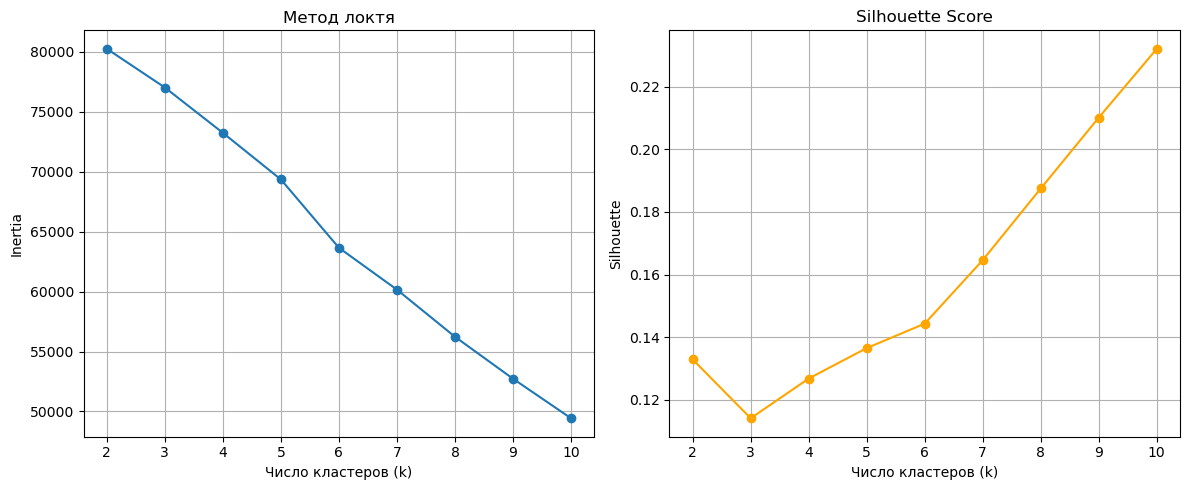

Оптимальное k (по Silhouette Score) = 10, Silhouette Score = 0.232


In [45]:
# 
# как DataFrame с признаками клиентов, например, как в источниках [1, 4].
# df_scaled уже является 2D-массивом, подходящим для KMeans.
X_data = df_scaled

inertia = []
silhouette = []
K = range(2, 11) # Диапазон числа кластеров для оценки [6]

# Цикл по числу кластеров — собираем метрики
for k in K:
    # Инициализация KMeans для стандартных данных (не временных рядов)
    # 'n_init="auto"' добавлен для соответствия рекомендациям sklearn и примерам в источниках [5, 7].
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    model.fit(X_data)
    inertia.append(model.inertia_)
    silhouette.append(silhouette_score(X_data, model.labels_))

# Визуализация после цикла для методов локтя и силуэта
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K, silhouette, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Silhouette')
plt.grid(True)

plt.tight_layout()
plt.show()

# Определение и вывод оптимального k на основе Silhouette Score
best_k_silhouette = K[np.argmax(silhouette)]
print(f'Оптимальное k (по Silhouette Score) = {best_k_silhouette}, Silhouette Score = {max(silhouette):.3f}')


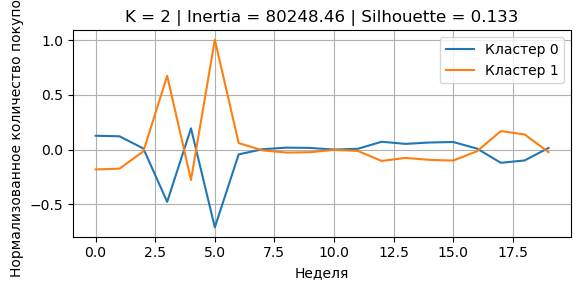

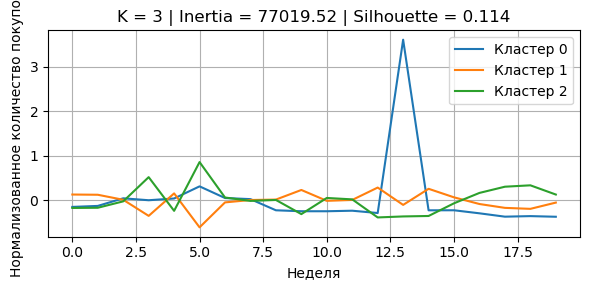

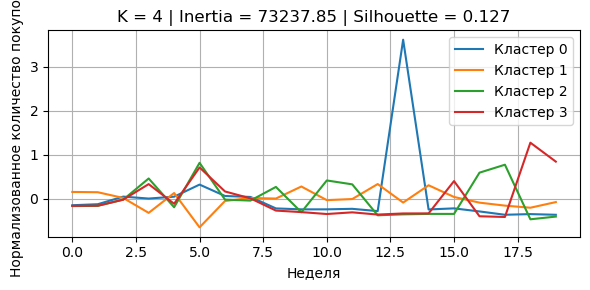

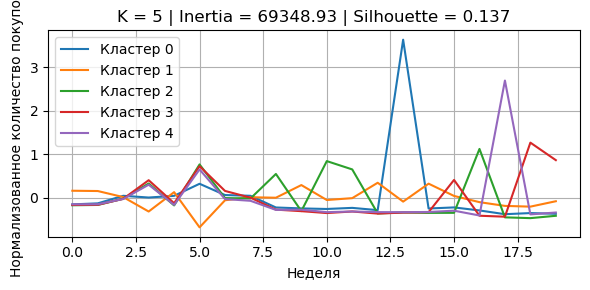

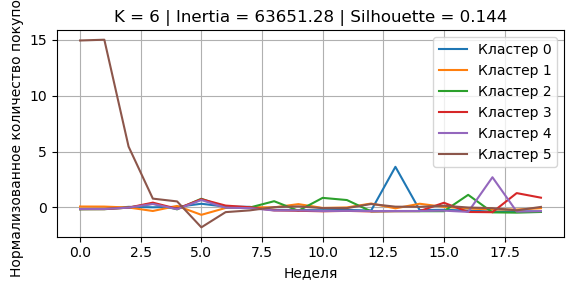

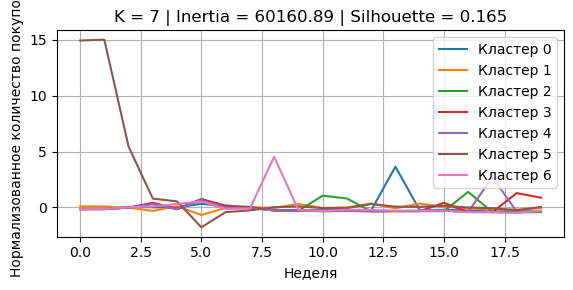

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
df_scaled = df_scaled.drop(columns=["cluster", "Cluster"], errors="ignore").copy()
# Убедимся, что входные данные — двумерные временные ряды
ts_flat = df_scaled.squeeze()
K = range(2, 8)  # можешь изменить диапазон по желанию

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(ts_flat)

    inertia = model.inertia_
    silhouette = silhouette_score(ts_flat, labels)

    # Визуализация центров кластеров
    cluster_centers = model.cluster_centers_
    
    plt.figure(figsize=(6, 3))
    for i in range(k):
        plt.plot(cluster_centers[i], label=f'Кластер {i}')
    
    plt.title(f'K = {k} | Inertia = {inertia:.2f} | Silhouette = {silhouette:.3f}')
    plt.xlabel('Неделя')
    plt.ylabel('Нормализованное количество покупок')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


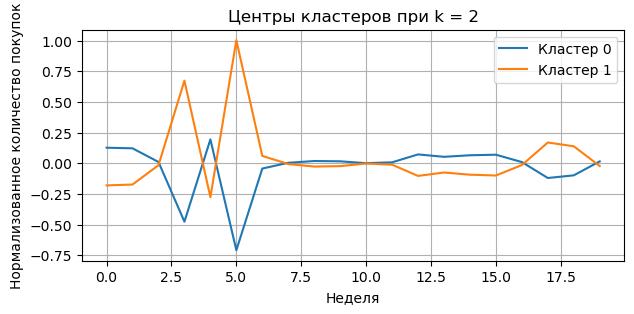

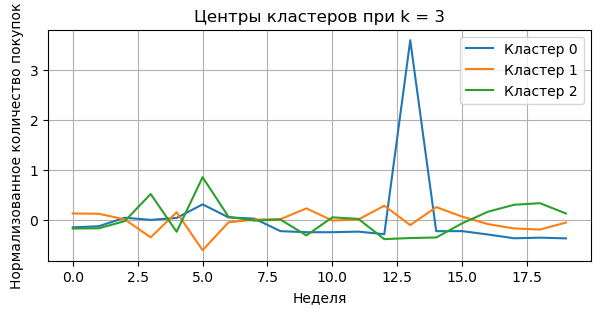

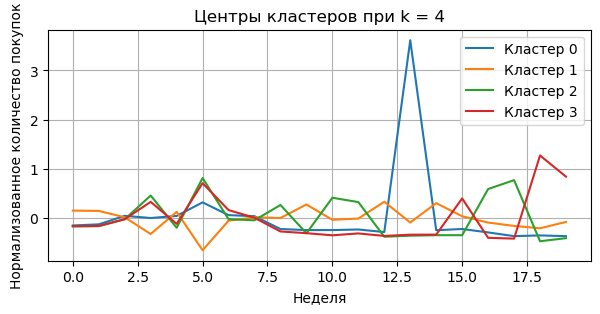

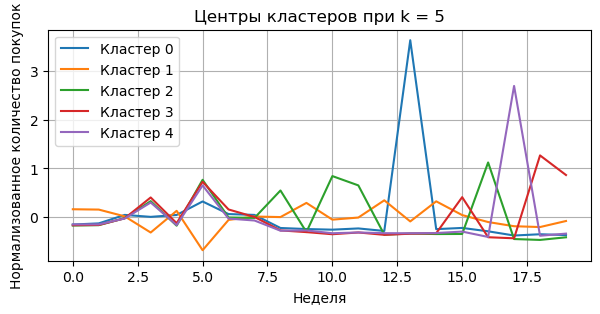

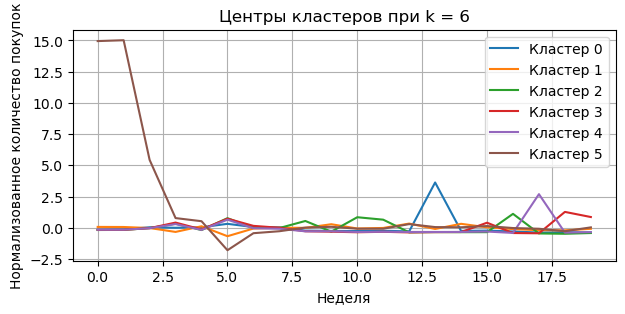

In [40]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Убедимся, что входные данные 2D (n_clients, n_weeks)
ts_flat = df_scaled.squeeze()

K = range(2, 7)  # можно расширить диапазон по желанию

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(ts_flat)
    
    # Расчёт центров кластеров
    cluster_centers = model.cluster_centers_
    
    # Визуализация
    plt.figure(figsize=(7, 3))
    for i in range(k):
        plt.plot(cluster_centers[i], label=f'Кластер {i}')
    plt.title(f'Центры кластеров при k = {k}')
    plt.xlabel('Неделя')
    plt.ylabel('Нормализованное количество покупок')
    plt.legend()
    plt.grid(True)
    plt.show()


### DTW 

In [41]:
df_scaled

,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,0.255510,0.249773,-0.025726,-0.574352,-0.115814,-1.420457,-0.196647,-0.765990,0.644704,-0.314984,-0.369425,0.383600,-0.387411,0.177115,-0.358107,0.348556,-0.452512,0.470474,-0.558405,0.557832
12348,0.231925,-0.029851,0.012885,-0.623908,0.564906,-0.563586,1.400349,0.011690,0.849748,-0.314984,-0.369425,0.544159,-0.387411,-0.369116,-0.358107,-0.356311,-0.039665,-0.490017,-0.558405,1.944187
12349,-0.112778,-0.034268,-0.025282,0.671830,-0.299792,1.092885,-1.877248,-1.722045,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,3.001947,-0.449443
12350,-0.200265,-0.192639,-0.030242,0.671830,-0.299792,1.092885,1.807926,-0.378401,-0.310401,5.550850,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,-0.449443
12352,-0.131929,0.049025,-0.019194,-0.461711,-0.017254,-0.952872,0.773600,-0.473246,-0.310401,0.720163,0.966029,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,1.153546,-0.490017,0.069892,-0.449443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,-0.230905,-0.209754,-0.032055,0.671830,-0.299792,1.092885,-1.877248,-1.722045,-0.310401,-0.314984,4.565946,-0.336014,-0.387411,-0.369116,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,-0.449443
18281,-0.229091,-0.220857,-0.039390,0.671830,-0.299792,1.092885,-1.350795,2.308888,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,5.153886,-0.358107,-0.356311,-0.452512,-0.490017,-0.558405,-0.449443
18282,-0.219213,-0.210037,-0.035683,-0.604453,0.687001,-0.098990,-0.210146,0.965244,-0.310401,-0.314984,-0.369425,-0.336014,-0.387411,-0.369116,-0.358107,3.045205,-0.452512,-0.490017,-0.558405,1.369247


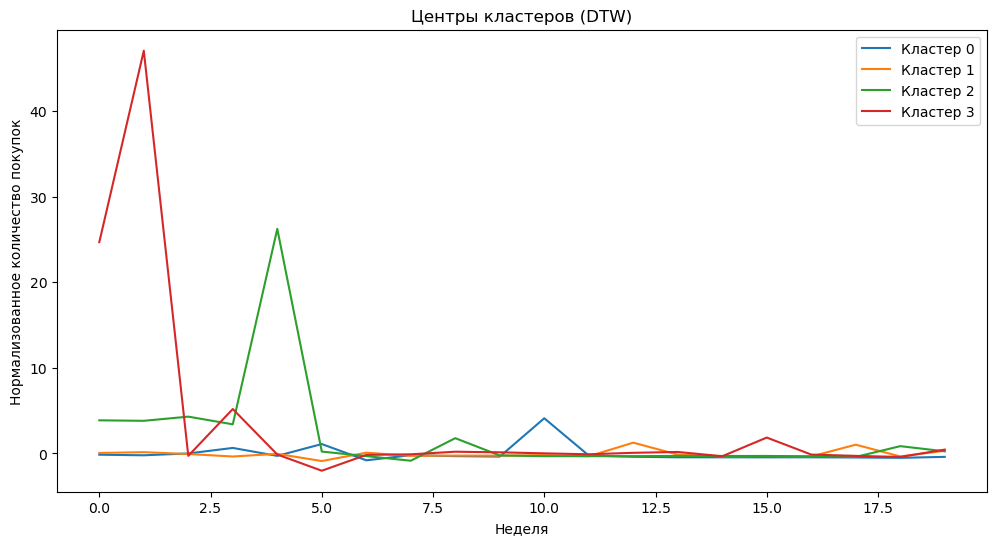

In [42]:
# Ячейка 2: TimeSeriesKMeans с DTW или Soft-DTW
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

# DTW-кластеризация
model_dtw = TimeSeriesKMeans(n_clusters=4, metric="dtw", random_state=42)
labels_dtw = model_dtw.fit_predict(ts_flat)

# Визуализация центров кластеров
plt.figure(figsize=(12, 6))
for cluster_idx in range(model_dtw.n_clusters):
    plt.plot(model_dtw.cluster_centers_[cluster_idx].ravel(), label=f'Кластер {cluster_idx}')
plt.title('Центры кластеров (DTW)')
plt.xlabel('Неделя')
plt.ylabel('Нормализованное количество покупок')
plt.legend()
plt.show()


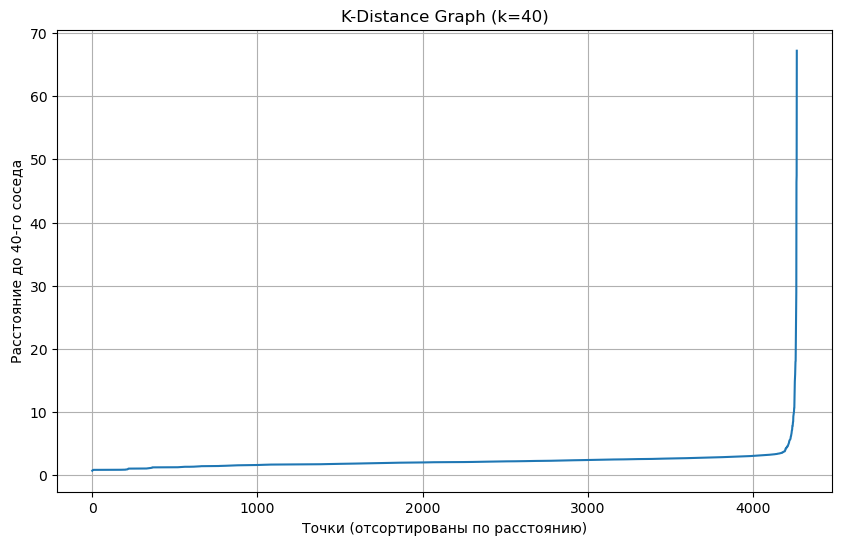

Пожалуйста, проанализируйте график K-Distance для определения подходящего значения eps. Ищите 'локоть' (резкое изменение наклона) на графике.
Рекомендуемый min_samples = 40 (это число признаков * 2).

Распределение клиентов по кластерам (включая шум, помеченный как -1):
Cluster
-1     2041
 0      319
 1       95
 2     1210
 3       62
 4      164
 5      128
 6       63
 7       56
 8       41
 9       43
 10      45
Name: count, dtype: int64

Silhouette Score (исключая шум): 0.405


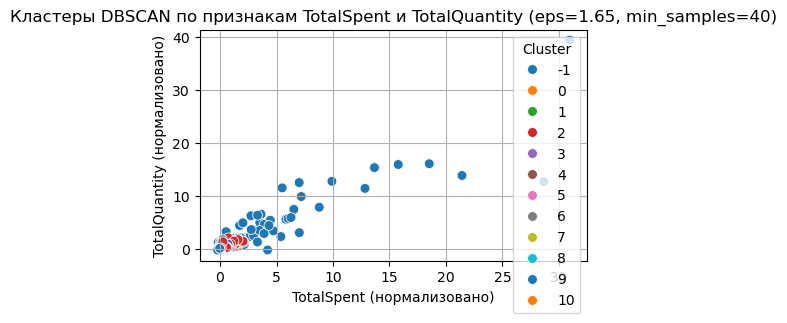


Профиль кластеров (средние значения ненормализованных признаков):


,TotalQuantity,TotalSpent,AvgCheck,WeeklyFrequency,AvgPurchaseInterval,MonthlyCV,AvgHour,AvgDow,MonthShare_1,MonthShare_2,MonthShare_3,MonthShare_4,MonthShare_5,MonthShare_6,MonthShare_7,MonthShare_8,MonthShare_9,MonthShare_10,MonthShare_11,MonthShare_12
Cluster,,,,,,,,,,,,,,,,,,,,
-1,1538.06,2668.36,71.34,0.31,5.85,2.19,12.62,2.67,0.07,0.07,0.07,0.07,0.10,0.09,0.09,0.09,0.08,0.09,0.10,0.10
0,303.25,474.84,22.14,0.98,0.28,3.38,12.82,2.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.97,0.01
1,174.59,325.58,23.39,1.02,0.05,3.46,12.69,2.36,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1408.68,2455.42,23.76,0.53,1.41,2.12,12.47,2.49,0.03,0.03,0.04,0.03,0.04,0.04,0.04,0.04,0.24,0.31,0.12,0.06
3,193.06,360.06,20.89,0.99,0.06,3.46,12.06,2.11,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,211.46,340.29,25.99,0.90,0.61,3.42,12.75,2.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99
5,182.66,329.08,27.19,1.02,0.21,3.46,12.18,2.36,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,171.41,286.01,20.74,1.04,0.02,3.46,12.95,1.87,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
7,195.25,376.34,26.43,0.98,0.12,3.45,12.18,2.23,0.00,0.00,0.00,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [47]:
# Полный код для применения DBSCAN к 


from sklearn.neighbors import NearestNeighbors # Для подбора параметра eps

# Предполагается, что df_scaled уже загружен и доступен.
# df_scaled - это DataFrame с нормализованными признаками клиентов.
# Пример структуры df_scaled, как указано в источниках:
# Index(['TotalQuantity', 'TotalSpent', 'AvgCheck', 'WeeklyFrequency',
#        'AvgPurchaseInterval', 'MonthlyCV', 'AvgHour', 'AvgDow',
#        'MonthShare_1', ..., 'MonthShare_12'], dtype='object') [2]

X_data = df_scaled.copy() # Работаем с копией, чтобы не изменять исходный df_scaled

# --- Шаг 1: Подбор параметра eps (не содержится напрямую в источниках, но является важным шагом) ---
# Для DBSCAN крайне важен правильный выбор параметра eps.
# Один из распространенных методов - построение k-distance графика.
# Найдем расстояние до k-го ближайшего соседа для каждой точки.
# k обычно выбирается равным min_samples. Начнем с min_samples = 2 * n_features или 2 * log(n_samples)
# В нашем случае df_scaled имеет 20 признаков [7].
# Пусть min_samples будет, например, 40 (2 * 20 признаков).

# Определим количество признаков (колонок) в df_scaled, если оно не явно задано
n_features = X_data.shape[1]
min_samples_val = n_features * 2 # Общая эвристика для min_samples

# Найдем расстояния до min_samples_val-го ближайшего соседа
neigh = NearestNeighbors(n_neighbors=min_samples_val)
nbrs = neigh.fit(X_data)
distances, indices = nbrs.kneighbors(X_data)

# Сортируем расстояния до min_samples_val-го соседа и строим график
distances = np.sort(distances[:, min_samples_val-1], axis=0) # Важно: min_samples_val-1, т.к. индексы с 0
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'K-Distance Graph (k={min_samples_val})')
plt.xlabel('Точки (отсортированы по расстоянию)')
plt.ylabel(f'Расстояние до {min_samples_val}-го соседа')
plt.grid(True)
plt.show()

print(f"Пожалуйста, проанализируйте график K-Distance для определения подходящего значения eps. "
      f"Ищите 'локоть' (резкое изменение наклона) на графике.")
print(f"Рекомендуемый min_samples = {min_samples_val} (это число признаков * 2).")

# --- Шаг 2: Применение DBSCAN с выбранными параметрами ---
# На основе анализа k-distance графика, выберите значение eps.
# Например, если "локоть" находится примерно на уровне 0.5.
# Замените 'ваш_eps_здесь' на выбранное вами значение.
# Если вы не уверены, начните с небольшого значения, например 0.5-1.0,
# и корректируйте его, наблюдая за результатами.

eps_value = 1.65 # Это примерное значение. В реальном анализе подбирается по графику K-Distance.
# min_samples_val определено выше

dbscan_model = DBSCAN(eps=eps_value, min_samples=min_samples_val)
cluster_labels = dbscan_model.fit_predict(X_data)

# Добавляем метки кластеров в df_scaled
X_data['Cluster'] = cluster_labels

# --- Шаг 3: Анализ результатов кластеризации ---
print("\nРаспределение клиентов по кластерам (включая шум, помеченный как -1):")
print(X_data['Cluster'].value_counts().sort_index())

# Рассчитаем Silhouette Score для оценки качества кластеризации
# Исключаем шумовые точки (-1), так как Silhouette Score не рассчитывается для них.
# Silhouette Score используется в источниках для оценки качества кластеризации [9-12].
n_clusters_found = len(np.unique(cluster_labels[cluster_labels != -1]))
if n_clusters_found > 1:
    # Важно: silhouette_score требует, чтобы было минимум 2 кластера,
    # и чтобы не все точки были шумом.
    score = silhouette_score(X_data[X_data['Cluster'] != -1].drop(columns=['Cluster']),
                             X_data[X_data['Cluster'] != -1]['Cluster'])
    print(f"\nSilhouette Score (исключая шум): {score:.3f}")
else:
    print("\nНедостаточно кластеров (или слишком много шума) для расчета Silhouette Score.")

# --- Шаг 4: Визуализация результатов (пример) ---
# Для многомерных данных (20 признаков) прямая визуализация затруднена.
# Можно использовать методы понижения размерности (например, PCA, UMAP, t-SNE)
# для визуализации кластеров в 2D или 3D пространстве.
# Источники упоминают UMAP для понижения размерности [13, 14].

# Пример: Визуализация распределения двух признаков по кластерам
# Выберите два признака из df_scaled для визуализации.
# Например, 'TotalSpent' и 'TotalQuantity' [1, 15].

plt.figure(figsize=(5, 3))
sns.scatterplot(data=X_data, x='TotalSpent', y='TotalQuantity', hue='Cluster', palette='tab10', legend='full', s=50)
plt.title(f'Кластеры DBSCAN по признакам TotalSpent и TotalQuantity (eps={eps_value}, min_samples={min_samples_val})')
plt.xlabel('TotalSpent (нормализовано)')
plt.ylabel('TotalQuantity (нормализовано)')
plt.grid(True)
plt.show()

# Если интересно, можно посмотреть средние значения признаков для каждого кластера
# Чтобы получить осмысленные средние значения, лучше использовать df_features (немасштабированные)
# и затем добавить к ним метки кластеров.
# df_features содержит ненормализованные признаки [15].
# Предполагается, что df_features также доступен и имеет те же индексы, что и df_scaled.
try:
    df_features['Cluster'] = cluster_labels
    print('\nПрофиль кластеров (средние значения ненормализованных признаков):')
    cluster_profile_raw = df_features.groupby('Cluster').mean().round(2)
    display(cluster_profile_raw)
except NameError:
    print("\nПеременная df_features не найдена. Невозможно отобразить профиль кластеров на ненормализованных данных.")